# Week 6 Discussion: Boosting in Trees: XGBoost

## Objectives

In this week's discussion, we will learn:
* Getting familiar with XGBoost and marginal improvements

## Preparing the Data

Before importing the data, as usual, we import _pandas_ library to simplify data manipulation.

In [1]:
import pandas as pd

In this discussion we use _Carseats_ dataset which is the data of the sales of child car seats at 400 different stores. For more information on the dataset, please look it up!

In [2]:
#the data can be downloaded from "https://github.com/jcrouser/islr-python/blob/master/data/Carseats.csv"
df = pd.read_csv('Carseats.csv')

We now print out the dataset to gain more insight in it:

In [3]:
print (df.head(5))

   Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0   9.50        138      73           11         276    120       Bad   42   
1  11.22        111      48           16         260     83      Good   65   
2  10.06        113      35           10         269     80    Medium   59   
3   7.40        117     100            4         466     97    Medium   55   
4   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US  
0         17   Yes  Yes  
1         10   Yes  Yes  
2         12   Yes  Yes  
3         14   Yes  Yes  
4         13   Yes   No  


For classification, we build a new label which is indicative of sales being more than 8 (high sales) or not.

In [4]:
import numpy as np
df['high_sales'] = np.where(df['Sales']>8, 'yes', 'no')

By printing out the dataset, we have:

In [5]:
df.head(5)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,high_sales
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes,yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes,yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes,yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes,no
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No,no


As discussed above, the _Sales_ column in the dataset will be our label for the regression problem and _high sales_ will be our label for the classification problem. All the other columns will be our features.

In [6]:
X      = df.drop (labels=['Sales', 'high_sales'], axis=1)
y_clas = df[['high_sales']]
y_regr = df[['Sales']]

We used to convert the categorical to numerical before... not anymore!

In [7]:
X_cat = X.select_dtypes(exclude=['int64', 'float64'])                                                                                                         
X_dog = X.select_dtypes(include=['int64', 'float64'])                                                                                                         
                                                                                                                                                              
X_cat = pd.get_dummies(X_cat)                                                                                                                                 
X = pd.concat([X_cat, X_dog], axis=1)

As discussed last week, changing the name of the outputs to numbers from $0$ to $k-1$ with $k$ being the number of different classes we have:

In [8]:
highsales2number_dict = {
    'no' :0,
    'yes':1
}


y_clas=y_clas.replace({"high_sales": highsales2number_dict})

## XGBoost

In this week's discussion we get familiar with XGBoost, a gradient boosting framework. It has been chosen by many winning teams in many competitions. It is a really good model to know about, look it up!

## Building a Single XGB Model

We now build a a single decision tree classifier on our whole data:

In [10]:
from xgboost import XGBClassifier

xgb_c = XGBClassifier(max_depth=5, n_estimators=100, n_jobs=-1)

xgb_c.fit(X, y_clas.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

## Defining a Function for Cross-validation of a Single Model

In the code snippet below a function is defined to cross validate a single XGB model. Before feeding the data into the model, we mean impute it. This step happens after train-test splitting since the mean of the training data is used for the imputation of testing data.

In [12]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier, XGBRegressor

from sklearn.metrics import mean_squared_error

def cross_validate_single_xgb_model(model_type, X, y, n_folds, args):
    
    performance = 0
    
    if model_type.endswith("classifier"):
        splitter = StratifiedKFold(n_splits=n_folds, shuffle=True).split(X,y)
    elif model_type.endswith("regressor"):
        splitter =           KFold(n_splits=n_folds, shuffle=True).split(X)
        
    for train_index, test_index in splitter:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()

        #mean imputation
        mean_imputer = SimpleImputer()
        X_train      = mean_imputer.fit_transform(X_train)
        X_test       = mean_imputer.    transform(X_test)
        
        ##train/test
        if model_type    == "xgb_classifier":
            model   = XGBClassifier(**args)
            
        elif model_type  == "xgb_regressor":
            model   = XGBRegressor (**args)
            
        model.fit(X_train, y_train)
        pred   = model.predict(X_test)
        
        if  model_type.endswith("classifier"):
            performance_contrib = roc_auc_score(y_test, pred)/n_folds
        elif model_type.endswith("regressor"):
            performance_contrib = mean_squared_error(y_test, pred)/n_folds

        
        performance += performance_contrib
    
    return performance

Python Tip:
    if you have a function _f_ that takes as input for example two arguments, _A_ and _B_, you can also provide that in this fashion:
<br>
<br>
$$
f(**\{"A":some\_val, "B":some\_val\})
$$
<br>
This is helpful when you do not know the exact arguments you are passing. But make sure to always provide required arguments.

Using the function developed above, we assess the AUC of a single classification XGB:

In [13]:
print ("%.2f"%cross_validate_single_xgb_model("xgb_classifier", X, y_clas,\
                                        10,\
                                       {"max_depth":5,\
                                        "n_estimators":100}))

0.84


## Takes long? Make It Parallel !

Before delving into comparisons, similar to the last week, we will set up the parallel comupation platform for cross validating different arguments.

In [15]:
from joblib import Parallel, delayed
import multiprocessing 
from itertools import product

num_processes = 20

def cross_validate_xgb_models(model, X, y, n_folds, args):
            
    arg_dict_vec = [dict(zip(args.keys(), values))\
                    for values in product(*args.values())]

    
    results = Parallel(n_jobs=num_processes)\
              (delayed(cross_validate_single_xgb_model)\
              (model, X, y, n_folds, arg_dict)\
              for arg_dict in arg_dict_vec)
    
    names   = [name_creator(model, n_folds, arg_dict)\
              for arg_dict in arg_dict_vec]
    
    auc_dict = dict(zip(names, results))
        
    return auc_dict

what does the code snippet in lines 9 and 10 do? Let's see:

In [16]:
args = {'A':[1,2], 'B':['a','b']}
[dict(zip(args.keys(), values)) for values in product(*args.values())]

[{'A': 1, 'B': 'a'},
 {'A': 2, 'B': 'a'},
 {'A': 1, 'B': 'b'},
 {'A': 2, 'B': 'b'}]

The code snippet above creates a vector of dictionaries that have the product of the two lists.

## Saving Results

Similar to the previous weeks, we will save the models in the results folder. In the following piece of code, we first check if it exists, and if not, we will create it:

In [17]:
import os

rslt_addr = "./results/"
if not os.path.exists(rslt_addr):
    os.makedirs(rslt_addr)

Following the file naming convention discussed last week, we will have:

In [18]:
def name_creator(model,n_folds, args):

    name = "model_%s__n_folds_%d"%(model, n_folds)
    
    def describe_in_string(vec):
        
        if not isinstance(vec, list):
            return vec
        
        if len(vec)==0:
            return "NA"
        
        if isinstance(vec[0], str):
            return '_'.join(vec)
    
        if len(vec)==1:
            return "%d"%vec[0]
    
        return "%d_%d"%(np.min(vec), np.max(vec))
    
    for arg in sorted(args.keys()):
            name += "__%s_%s"%(arg, describe_in_string(args[arg]))
    
    return name

We see an example here:

In [19]:
import numpy as np

model      = "xgb_classifier"
n_folds    = 5
max_depth = 5

print ('\n'*1, name_creator(model, n_folds, {"max_depth":max_depth}), '\n'*2)


 model_xgb_classifier__n_folds_5__max_depth_5 




The function below either loads the results or computes it:

In [20]:
import pickle
import os
import numpy as np

def cross_validate_args (model, X, y, n_folds, args):
    
    rslt_dict_name = name_creator(model, n_folds, args)
    rslt_dict_addr = os.path.join(rslt_addr, rslt_dict_name)
    
    
    if os.path.isfile(rslt_dict_addr):
        with open(rslt_dict_addr,"rb") as rslt_dict_handle:
            rslt_dict = pickle.load(rslt_dict_handle)
    else:
        rslt_dict = cross_validate_xgb_models(model, X, y, n_folds, args)
        with open(rslt_dict_addr,"wb") as rslt_dict_handle:
            pickle.dump(rslt_dict, rslt_dict_handle)

    return rslt_dict

Having our framework set up, we now begin the experiments.

## Boosting

As we saw in the course, boosting works as gradually adding to the model by introducing more weak learners.

In [21]:
n_folds    = 10
model      = "xgb_classifier"
args       = {"max_depth"    : [2,4,6,8],\
              "n_estimators" : [x for x in range(1,150+1)]}

rslt_dict = cross_validate_args (model, X, y_clas, n_folds, args)

Here, we define a function to plot the performance of the models we have developed. 

In [22]:
import matplotlib.pyplot as plt
import random
random.seed(4)
plt.rcParams.update({'font.size': 18})
import numpy as np

def plot_performance(model, args, n_folds, rslt_dict):

    for max_depth in args['max_depth']:
        plt.figure(figsize = (16,10)) 

        for n_estimators in args['n_estimators']:
            plt.scatter(n_estimators, rslt_dict[name_creator(model,n_folds,\
                       {'max_depth':max_depth, 'n_estimators':n_estimators})],\
                        color='black')

        if model.endswith('classifier'):
            perf_metric = 'AUC'
        elif model.endswith('regressor'):
            perf_metric = 'MSE'
            
        plt.title('Performance measured by %s for max depth = %d\n with increasing number of estimators'\
                  %(perf_metric, max_depth))
        
        plt.show()

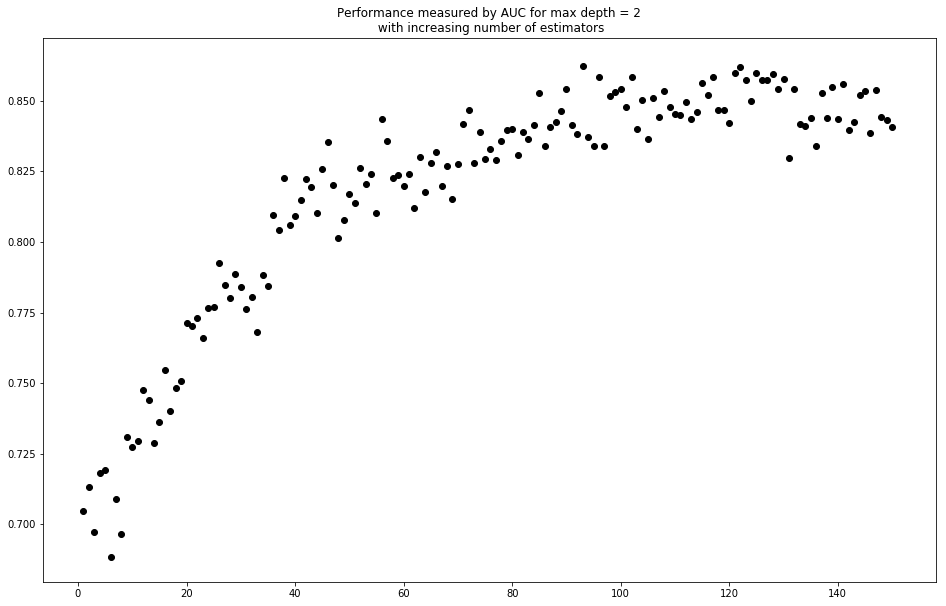

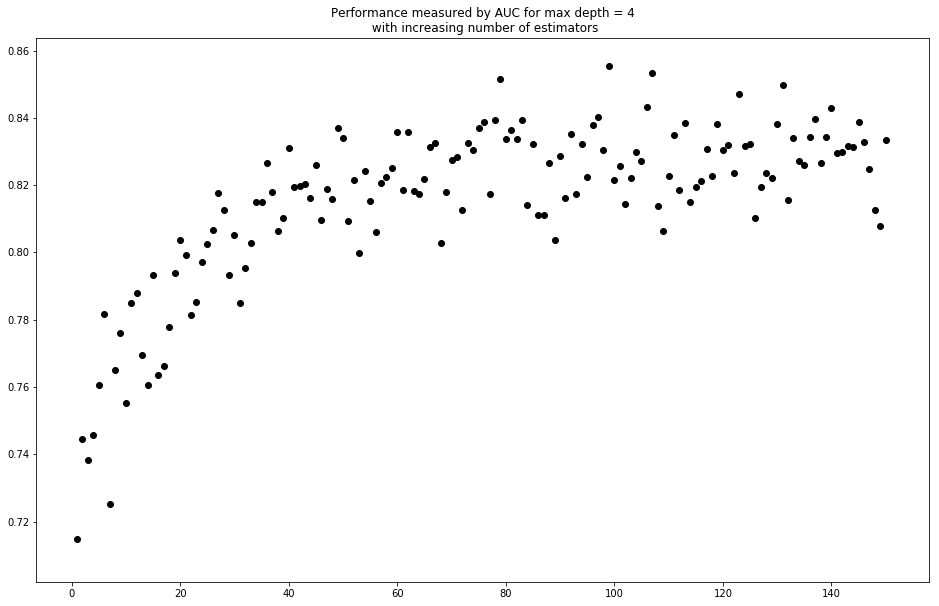

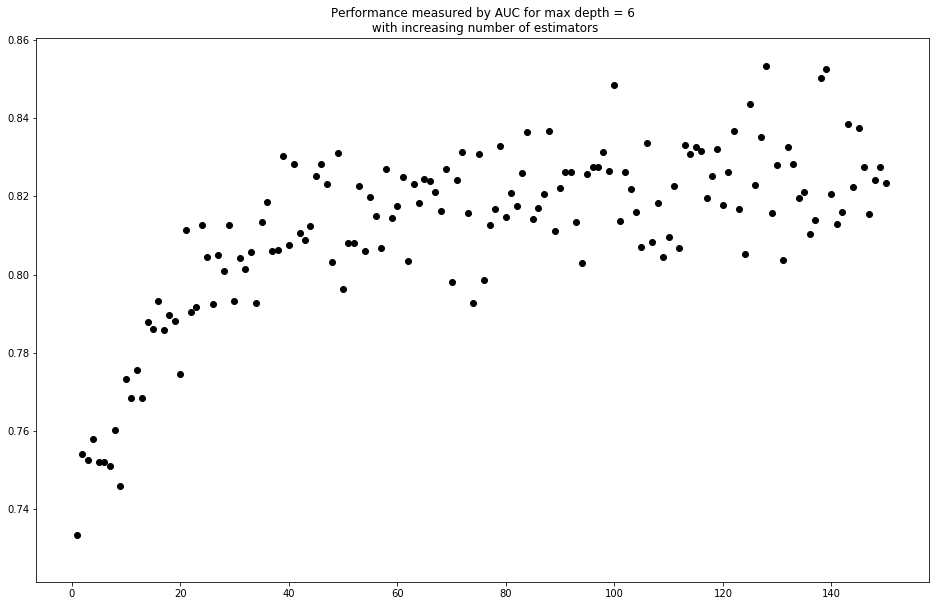

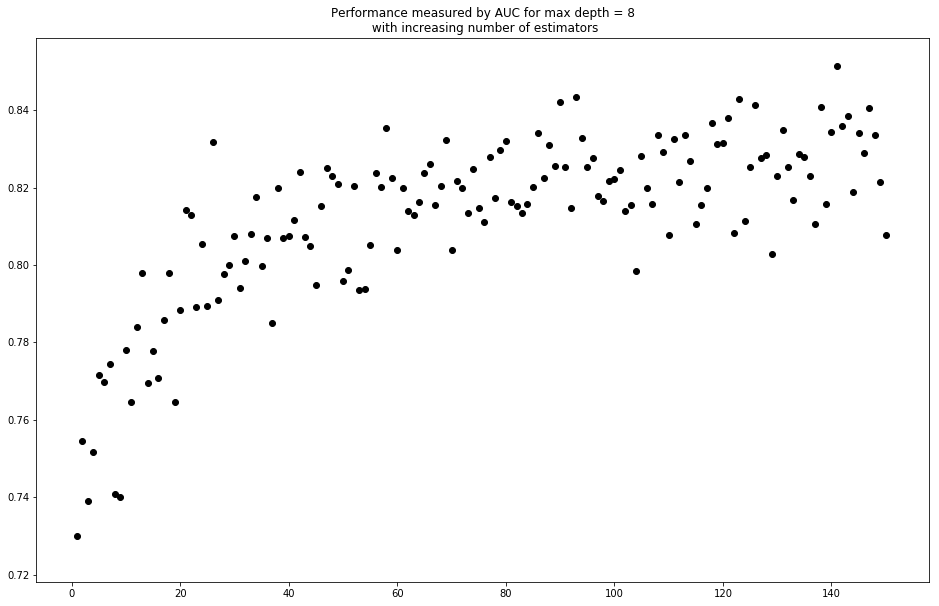

In [23]:
plot_performance(model, args, n_folds, rslt_dict)

## XGB in Regression

In this discussion we use _Boston_ dataset which is the data collected on housing in the area of Boston Mass. For more information on the dataset, please look it up!

In [24]:
#the data can be downloaded from "https://github.com/jcrouser/islr-python/blob/master/data/Boston.csv"
df = pd.read_csv('Boston.csv')

In [25]:
df.head(5)

,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [26]:
X = df.drop (labels=['Unnamed: 0', 'medv'], axis=1, inplace=False)
y = df[['medv']]

Now if we cross validate different values for XGBoost regression, we have:

In [27]:
n_folds    = 10
model      = "xgb_regressor"
args       = {"max_depth"    : [2,4,6,8],\
              "n_estimators" : [x for x in range(1,151)]}

rslt_dict = cross_validate_args (model, X, y, n_folds, args)

Plotting the results:

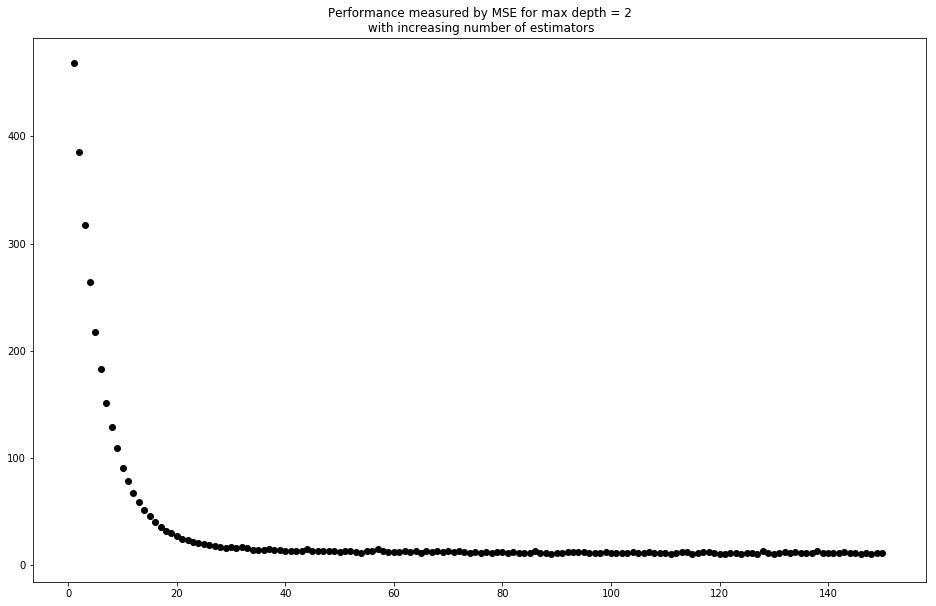

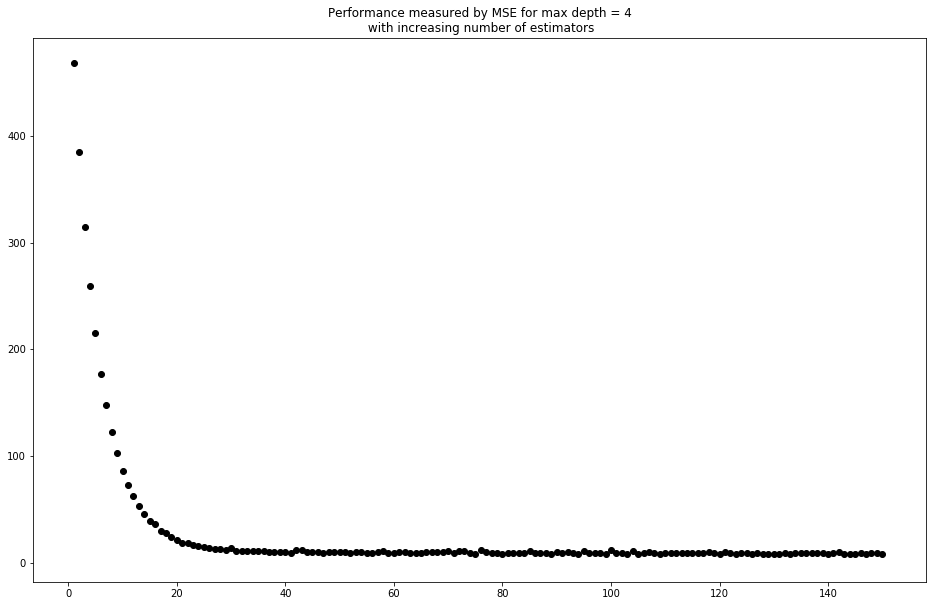

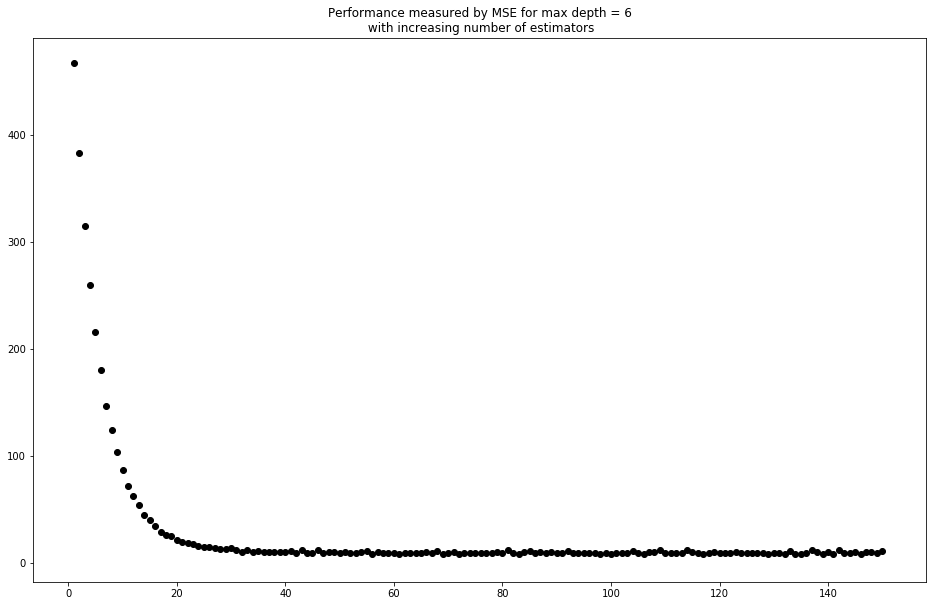

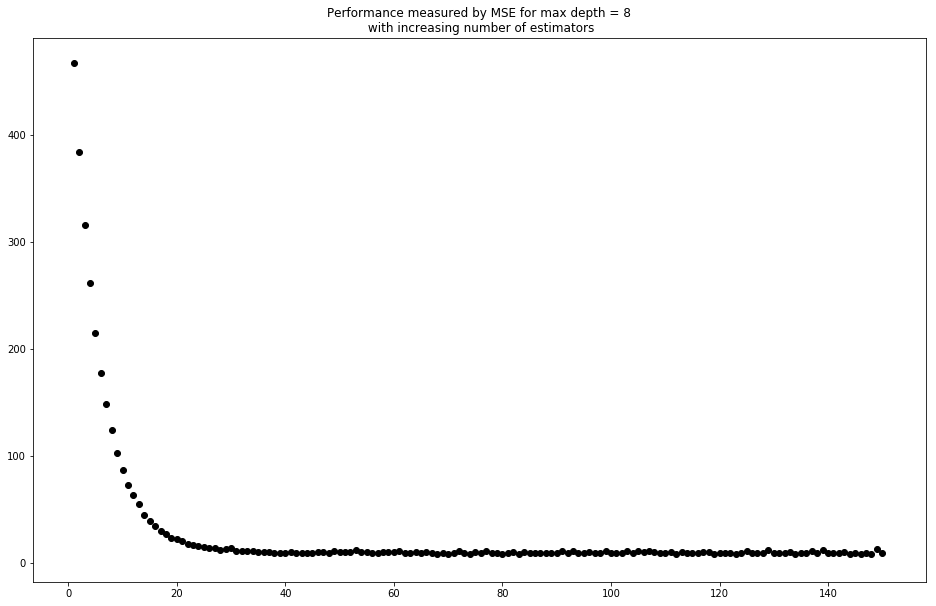

In [28]:
plot_performance(model, args, n_folds, rslt_dict)

As can be seen, the improvement vanishes as the number of trees in the model grows.